# 頂点被覆（Vertex Cover）
まず、Vertex Cover問題について説明します。次の図をみてください。

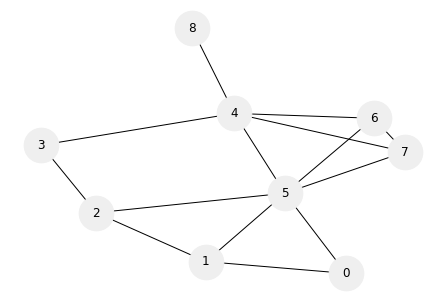

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

G = nx.Graph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8])
G.add_edges_from([(0,1),(0,5),(1,2),(1,5),(2,5),(2,3),(3,4),(4,5),(4,6),(4,7),(4,8),(5,6),(5,7),(6,7),])
nx.draw(G, **options)

これは頂点Vとその頂点を結ぶ辺Eからなる無向グラフ$G = \{V, E\}$です。この頂点のいくつかに色を塗ることを想定します。そのあとで、任意の辺を選んだときに、その辺の両端にある頂点の片方または両方に色がついているようにするのが条件です。その条件を満たすようにし、かつ色を塗る頂点数を最小限にする、というのがVertex Cover問題です。

## 準備
これをblueqatを使用して解いてみます。
blueqatがインストールされていない場合は、環境に併せて以下のようにインストールしてください。

In [1]:
!pip install blueqat

     |████████████████████████████████| 51kB 1.4MB/s 


必要なライブラリをimportし、blueqatオブジェクトをインスタンス化します。

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import blueqat.opt as wq

## QUBOの作成
解きたい問題のコスト関数は、

$ H = H_{A} + H_{B} $

で、$H_{A}, H_{B}$はそれぞれ、

$ \displaystyle H _ { A } = A \sum _ { u v \in E } \left( 1 - x _ { u } \right) \left( 1 - x _ { v } \right)$

$ \displaystyle H _ { B } = B \sum _ { v } x _ { v }$

です。$x_{u}, x_{v}$はその頂点に色が付いているときに1、付いていないときに0になるものとします。

まず、$H_{A}$ですが、これは辺で結ばれた2つの頂点u, vを選んだとき、片方または両方に色がついていれば0、どちらも色がついていなければコストがA上がる、というものになります。これを展開すると、

$ \displaystyle H _ { A } = A \sum _ { u v \in E } \left( 1 - x _ { u } - x _ { v } + x_{u}x_{v}\right)$

となり、第一項が定数項であるためコストの計算では無視できること、また$x \in \{0, 1\}$であることを利用すると、さらに次のように置き換えることができます。

$ \displaystyle H_{A} = A \sum _ { u v \in E } \left( - x_{u}x_{u} - x_{v}x_{v} + x_{u}x_{v}\right) $

つぎに、$H_{B}$についてですが、これは色が付いている頂点の1つについてコストがB上がることを意味します。これも同様に$x \in \{0, 1\}$であることを利用して、次のようにすることができます。

$ \displaystyle H_{B} = B \sum _ { u,v: u = v } x_{u}x_{v}$

以上でQUBOの形式にすることができました。

また、係数$A, B$については、頂点を1つ少なく選ぶ（コストがB下がる）より、両方とも色が付いていない状態をなしにする（両方とも色がついていないとコストがA上がる）ことを優先したいので、$A > B$である必要があります。

これをコードにすると次の通りです。

## コーディングと実行
まずは冒頭に掲げた無向グラフですが、次の配列で定義します。

In [0]:
edge_def = [
    [1,5],      # (0)と繋がっているものは(1)と(5)であるという意味
    [2,5],      # (1)と繋がっているものは(2)と(5)であるという意味
    [3,5],      #  :
    [4],        #  :
    [5,6,7,8],
    [6,7],
    [7],
    [],
    []
]

In [0]:
A = 1.0
B = 0.9
def get_qubo(edges):
    Q = np.zeros( (len(edges), len(edges)) )

    for u in range(len(edges)):
        for v in range(u, len(edges)):
            if u == v:
                Q[u][v] += B
            if v in edges[u]:    #xuとxvが繋がっているかどうか
                Q[u][v] +=  +A
                Q[u][u] +=  -A
                Q[v][v] +=  -A

    return Q

また、結果を表示する関数も定義しておきましょう。

In [0]:
def show_answer(list_x, energies = None, show_graph = False):
    print("Result x: " + str(list_x))
    print("Picked {} vertices: {}".format(sum(list_x), [x*i for i, x in enumerate(list_x) if x > 0] ))
    if energies is not None:
        print("Energy:" + str(a.E[-1]))
    if show_graph:
        plt.plot(a.E)
        plt.show()

次の通り5回実行してみます

In [13]:
for i in range(5):
    print("---{}回目".format(i+1))
    a = wq.opt()
    a.qubo = get_qubo(edge_def)
    answer = a.sa()
    show_answer(answer, a.E)

---1回目
Result x: [0, 1, 0, 1, 1, 1, 0, 1, 0]
Picked 5 vertices: [1, 3, 4, 5, 7]
Energy:-9.5
---2回目
Result x: [1, 0, 1, 0, 1, 1, 1, 0, 0]
Picked 5 vertices: [0, 2, 4, 5, 6]
Energy:-9.5
---3回目
Result x: [0, 1, 0, 1, 1, 1, 1, 0, 0]
Picked 5 vertices: [1, 3, 4, 5, 6]
Energy:-9.5
---4回目
Result x: [1, 0, 1, 0, 1, 1, 1, 0, 0]
Picked 5 vertices: [0, 2, 4, 5, 6]
Energy:-9.5
---5回目
Result x: [0, 1, 0, 1, 1, 1, 1, 0, 0]
Picked 5 vertices: [1, 3, 4, 5, 6]
Energy:-9.5


同じEnergy値で解は何種類か出てきましたので、基底状態はいくつかありそうですが、頂点数は概ね5でした。